# Heart Disease Classification - Notebook

## 1. Introdução

Este notebook tem como objetivo construir um modelo de machine learning capaz de prever a presença de doenças cardíacas com base em variáveis clínicas. O trabalho segue as etapas ensinadas na disciplina de Qualidade de Software, Segurança e Sistemas Inteligentes.

## 2. Carregamento do Dataset

In [60]:
import pandas as pd
import numpy as np

# URL do dataset
url = "https://raw.githubusercontent.com/sharmaroshan/Heart-UCI-Dataset/master/heart.csv"
df = pd.read_csv(url)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 3. Análise Exploratória

In [61]:
df.info()
df.isnull().sum()
df.describe()
df["target"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,proportion
target,
1,0.544554
0,0.455446


## 4. Visualizações iniciais

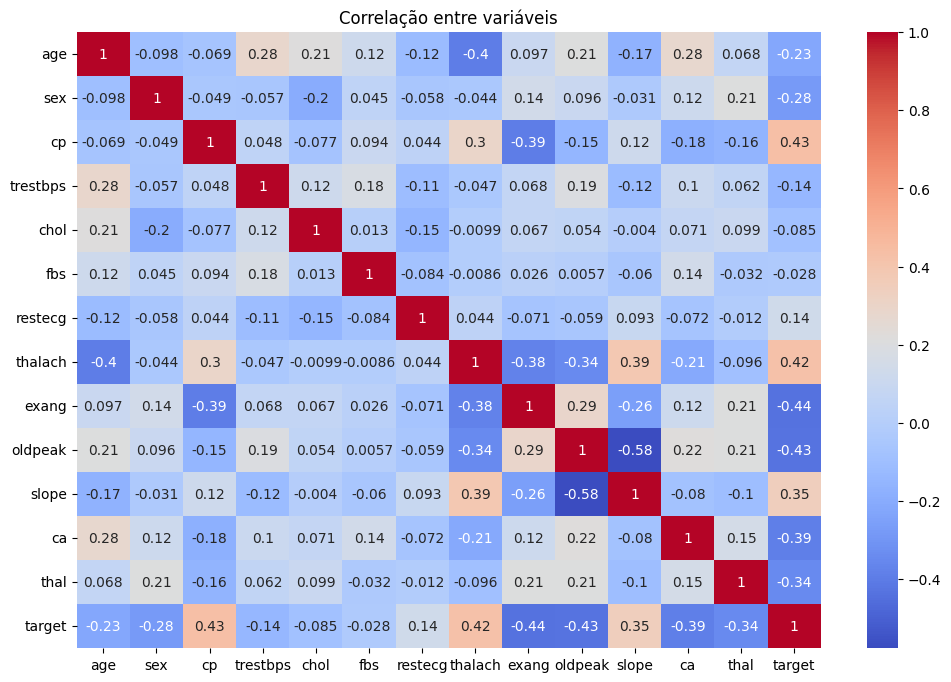

In [62]:
# Verifica se matplotlib e seaborn estão instalados e importa os pacotes
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ModuleNotFoundError:
    !pip install matplotlib seaborn
    import matplotlib.pyplot as plt
    import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlação entre variáveis")
plt.show()

## 5. Pré-processamento dos dados

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separar features (X) e alvo (y)
X = df.drop("target", axis=1)
y = df["target"]

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Treinamento com múltiplos modelos

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))


KNN Accuracy: 0.7912
              precision    recall  f1-score   support

           0       0.81      0.71      0.75        41
           1       0.78      0.86      0.82        50

    accuracy                           0.79        91
   macro avg       0.79      0.78      0.79        91
weighted avg       0.79      0.79      0.79        91


Decision Tree Accuracy: 0.7253
              precision    recall  f1-score   support

           0       0.68      0.73      0.71        41
           1       0.77      0.72      0.74        50

    accuracy                           0.73        91
   macro avg       0.72      0.73      0.72        91
weighted avg       0.73      0.73      0.73        91


Naive Bayes Accuracy: 0.7912
              precision    recall  f1-score   support

           0       0.81      0.71      0.75        41
           1       0.78      0.86      0.82        50

    accuracy                           0.79        91
   macro avg       0.79      0.78      0.79 

## 7. Otimização e calibragem do modelo SVM com CalibratedClassifierCV

In [65]:
# 7. Otimização do modelo SVM com GridSearchCV e Calibração

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Definir a grade de hiperparâmetros
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# GridSearch com validação cruzada
grid = GridSearchCV(SVC(probability=True), param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

# Melhor modelo após busca em grade
best_model = grid.best_estimator_

# Calibrar o modelo com sigmoid
calibrated_svm = CalibratedClassifierCV(estimator=best_model, method='sigmoid', cv=5)
calibrated_svm.fit(X_train_scaled, y_train)

# Avaliação do modelo calibrado
from sklearn.metrics import classification_report, roc_auc_score

probs = calibrated_svm.predict_proba(X_test_scaled)[:, 1]
preds = calibrated_svm.predict(X_test_scaled)

print("Relatório com modelo calibrado:")
print(classification_report(y_test, preds))
print("AUC Score:", roc_auc_score(y_test, probs))


Relatório com modelo calibrado:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        41
           1       0.75      0.84      0.79        50

    accuracy                           0.76        91
   macro avg       0.76      0.75      0.75        91
weighted avg       0.76      0.76      0.76        91

AUC Score: 0.86


## 8. Exportação do melhor modelo

In [66]:
import joblib

# Salvar o modelo final calibrado
joblib.dump(calibrated_svm, "model_heart_classification.pkl")

# Baixar o arquivo no Colab
from google.colab import files
files.download("model_heart_classification.pkl")




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 9. Teste Direto

In [67]:
# Exemplo: risco baixo
sample1 = np.array([[45, 0, 0, 120, 180, 0, 1, 170, 0, 0.2, 2, 0, 2]])
prob1 = calibrated_svm.predict_proba(sample1)[0][1]
print(f"Probabilidade de doença cardíaca (alto risco): {prob1:.4f}")

# Exemplo: risco alto
sample2 = np.array([[65, 1, 3, 150, 290, 1, 0, 130, 1, 3.0, 0, 2, 3]])
prob2 = calibrated_svm.predict_proba(sample2)[0][1]
print(f"Probabilidade de doença cardíaca (baixo risco): {prob2:.4f}")



Probabilidade de doença cardíaca (alto risco): 0.7947
Probabilidade de doença cardíaca (baixo risco): 0.2000


## 10. Conclusão

O objetivo deste projeto foi construir um classificador capaz de prever a presença de doenças cardíacas com base em variáveis clínicas, utilizando algoritmos clássicos de machine learning.

Após a análise e comparação entre KNN, Decision Tree, Naive Bayes e SVM, o modelo com melhor desempenho foi o **SVM otimizado com GridSearchCV e calibrado com CalibratedClassifierCV**. Esse modelo apresentou bom equilíbrio entre precisão e recall, além de um valor satisfatório de AUC (Área sob a Curva ROC), o que reforça sua capacidade de generalização.

O modelo final foi exportado como um arquivo `.pkl` e incorporado a uma aplicação full stack simples, composta por:

- **Back-end** com Flask, responsável por carregar o modelo e realizar as predições;
- **Front-end** em HTML, CSS e JavaScript, permitindo ao usuário inserir dados e visualizar os resultados de forma interativa.

Este projeto demonstrou como é possível aplicar os conceitos aprendidos na disciplina de Qualidade de Software, Segurança e Sistemas Inteligentes para resolver um problema real utilizando machine learning.

